## Basic Hooks tutorial

In [1]:
import sys
sys.path

['/home/fede/Documents/mhpc/breast_cancer_classifier',
 '/opt/miniconda/envs/phang/lib/python37.zip',
 '/opt/miniconda/envs/phang/lib/python3.7',
 '/opt/miniconda/envs/phang/lib/python3.7/lib-dynload',
 '',
 '/opt/miniconda/envs/phang/lib/python3.7/site-packages',
 '/opt/miniconda/envs/phang/lib/python3.7/site-packages/IPython/extensions',
 '/home/fede/.ipython']

In [2]:
sys.executable

'/opt/miniconda/envs/phang/bin/python'

In [3]:
import torch

In [4]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from tqdm import tqdm
from matplotlib import pyplot as plt
import numpy as np
# from torchsummary import summary
import os

### Model

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(800, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [6]:
use_cuda = torch.cuda.is_available()
use_cuda = False
device = torch.device("cuda" if use_cuda else "cpu")

model = Net().to(device)
print(model)

Net(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)


### Set Hyperparameters

In [7]:
batch_size=64

#number of epochs 
epochs=5

#learning rate
lr=0.01

# keep the momentum to 0, otherwise also freezed parameters 
# will move for the momentum contribution to parameters evolution
momentum=0.0

seed=1
torch.manual_seed(seed)
save_model=1

### Data

In [8]:
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])), batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])), batch_size=batch_size, shuffle=True, **kwargs)

0it [00:00, ?it/s]

9920512it [00:02, 4627566.99it/s]                             


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz


0it [00:00, ?it/s]

32768it [00:00, 85034.65it/s]                            
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:01, 1562280.88it/s]                           
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 33996.05it/s]            

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


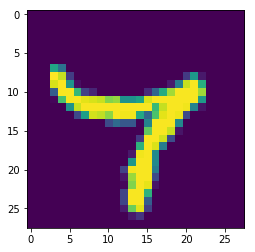

In [9]:
plt.imshow(next(iter(test_loader))[0][0][0,:,:])

In [10]:
batch_example = next(iter(test_loader))[0][0][0,:,:]

The hook can be function or a class called by the  __call__(self, *input, *** kwargs ) method of the nn.Module class.

### Set up hook

In [53]:
# empty_shape = list(next(iter(test_loader))[0].shape)
# empty_shape[0] = 0
# activation = {'conv1':torch.empty(empty_shape)}

activation = {'conv1':[]}
def get_activation(name):
    def hook(model, input, output):
        pass
        activation[name].append(output.detach())
    return hook


model = Net()
# the returned handle allows you to remove the hook
handle = model.conv1.register_forward_hook(get_activation('conv1'))
x = torch.randn(1, 25)
output = model(next(iter(test_loader))[0])
output.shape
# print(activation['conv1'][0].shape[1:])


torch.Size([64, 10])

In [12]:
# handle.remove()
# hook will no longer trigger

In [54]:
def test(model, device, test_loader, verbose = False):
    model.eval()
    loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    loss /= len(test_loader.dataset)
    acc = 100. * correct / len(test_loader.dataset)
    
    if verbose:
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            loss, correct, len(test_loader.dataset), acc))
    return loss,acc
    

In [55]:
test(model,device,test_loader)

(2.3156626861572267, 8.27)

In [56]:
len(activation['conv1'])

158

In [61]:
# activation is a list of the features of conv1.
# each item in the list corresponds to a batch

empty_shape = list(activation['conv1'][0].shape)
empty_shape[0] = 0
conv1_feat = torch.empty(empty_shape)
print(conv1_feat)
for i in activation['conv1']:
    # print(i.shape)
    conv1_feat = torch.cat((conv1_feat, i), 0)

tensor([], size=(0, 20, 24, 24))


In [62]:
conv1_feat.shape

torch.Size([10064, 20, 24, 24])